# Experiment number 7 (cifar10):

## tuning model from easy to hard: train model on 50% easy dataset and add data to model every few epochs until the model is trained on all dataset, in this experiment we test different approaches of tuning
## the metrics: EL2N, forget, flip, pred sum, std and km

### get dataset and metrics and print correlation


In [10]:
import os

import numpy as np
import pandas as pd
import torch
from torch import Tensor
import matplotlib.pyplot as plt


from train import ModelManager, DIR_ROOT_SAVE, DIR_ROOT_LOG
from utils import get_loader, get_cifar10

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 120

NOTEBOOK_NAME = 'tuning_cifar10'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')
PATH_KMEANS = os.path.join(DIR_ROOT_SAVE, 'k_means', 'cifar10.pt')
PATH_LOG = os.path.join(DIR_ROOT_LOG, NOTEBOOK_NAME, 'test_acc.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar10()
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
forget = torch.load(PATH_FORGET)['true_forget']
km = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_flip = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_sorted_forget = forget.sort()[1].numpy()
idx_random = np.arange(NUM_TRAIN)
np.random.shuffle(idx_random)
idx_sorted_km = np.argsort(km)

idx_sorted = {'random': idx_random, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum,
              'flip': idx_sorted_flip, 'forget': idx_sorted_forget, 'km': idx_sorted_km}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': forget.numpy(),
    'km': km
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,flip,forget,km
EL2N,1.000000,0.780107,-0.944299,0.658627,0.399751,0.529046
Std,0.780107,1.000000,-0.660269,0.586532,0.377763,0.496631
True p sum,-0.944299,-0.660269,1.000000,-0.627331,-0.350162,-0.460980
flip,0.658627,0.586532,-0.627331,1.000000,0.770378,0.394874
forget,0.399751,0.377763,-0.350162,0.770378,1.000000,0.253914
km,0.529046,0.496631,-0.460980,0.394874,0.253914,1.000000


In [11]:
# change to false in the first time you run this code
# after the first time the model will saved in models_data folder
already_trained = True

no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=already_trained)
if not already_trained:
    loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, True)
    no_prune.train(loader_train, loader_test, loader_test, EPOCHS)

exp_num = 0
already_trained_0 = True

acc={'no_prune':no_prune.data['valid']['acc']}

print()
for name, idx in idx_sorted.items():
    model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_exp{exp_num}', dir_=NOTEBOOK_NAME,
                                 load=already_trained_0)

    for epochs, presents in [(10, .5), (5, .6), (5, .7), (5, .8), (5, .9), (40, 1.)]:
        print(f'====     train model with {presents}% according to {name} method    ======')
        if not already_trained_0:
            loader_train = get_loader(dataset_train, idx[:round(presents * NUM_TRAIN)], batch_size=BATCH_SIZE,
                                      shuffle=True)
            model_manager.train(loader_train, loader_test, loader_test, epochs)
        acc[name]=model_manager.data['valid']['acc']
        print()


====     train model with 0.5% according to random method    ======

====     train model with 0.6% according to random method    ======

====     train model with 0.7% according to random method    ======

====     train model with 0.8% according to random method    ======

====     train model with 0.9% according to random method    ======

====     train model with 1.0% according to random method    ======

====     train model with 0.5% according to el2n method    ======

====     train model with 0.6% according to el2n method    ======

====     train model with 0.7% according to el2n method    ======

====     train model with 0.8% according to el2n method    ======

====     train model with 0.9% according to el2n method    ======

====     train model with 1.0% according to el2n method    ======

====     train model with 0.5% according to std method    ======

====     train model with 0.6% according to std method    ======

====     train model with 0.7% according to std met

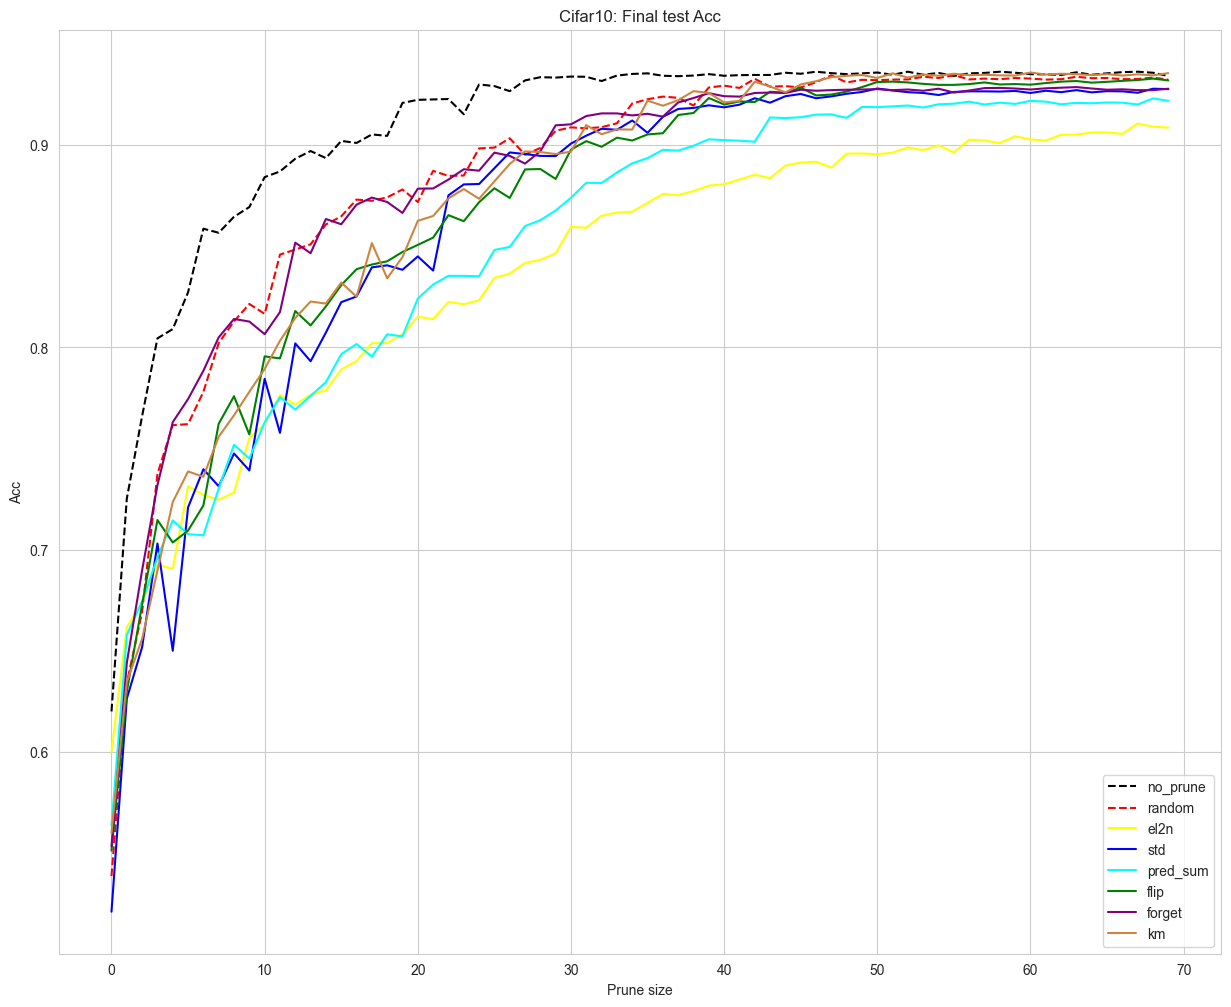

In [12]:
plt.figure(figsize=(15, 12))
#
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru','indianred',   'hotpink','darkorange','deepskyblue')
#          no       rand    el2n     std     sum     flip      forget   km      km5            km10             km100        km200
markers = ('dashed', 'solid')

for i, (prune_method,valid_acc) in enumerate(acc.items()):
        plt.plot(range(70), valid_acc[:70], label=prune_method,
                 c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()

In [13]:
exp_num = 1
already_trained_1 = True
print()
for name, idx in idx_sorted.items():
    model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_exp{exp_num}', dir_=NOTEBOOK_NAME,
                                 load=already_trained_1)
    for epochs, presents in [(20, .5), (10, .6), (10, .7), (10, .8), (10, .9), (20, 1.)]:
        print(f'====     train model with {presents}% according to {name} method    ======')
        if not already_trained_1:
            loader_train = get_loader(dataset_train, idx[:round(presents * NUM_TRAIN)], batch_size=BATCH_SIZE,
                                      shuffle=True)
            model_manager.train(loader_train, loader_test, loader_test, epochs)
        acc[name]=model_manager.data['valid']['acc']
        print()


====     train model with 0.5% according to random method    ======

====     train model with 0.6% according to random method    ======

====     train model with 0.7% according to random method    ======

====     train model with 0.8% according to random method    ======

====     train model with 0.9% according to random method    ======

====     train model with 1.0% according to random method    ======

====     train model with 0.5% according to el2n method    ======

====     train model with 0.6% according to el2n method    ======

====     train model with 0.7% according to el2n method    ======

====     train model with 0.8% according to el2n method    ======

====     train model with 0.9% according to el2n method    ======

====     train model with 1.0% according to el2n method    ======

====     train model with 0.5% according to std method    ======

====     train model with 0.6% according to std method    ======

====     train model with 0.7% according to std met

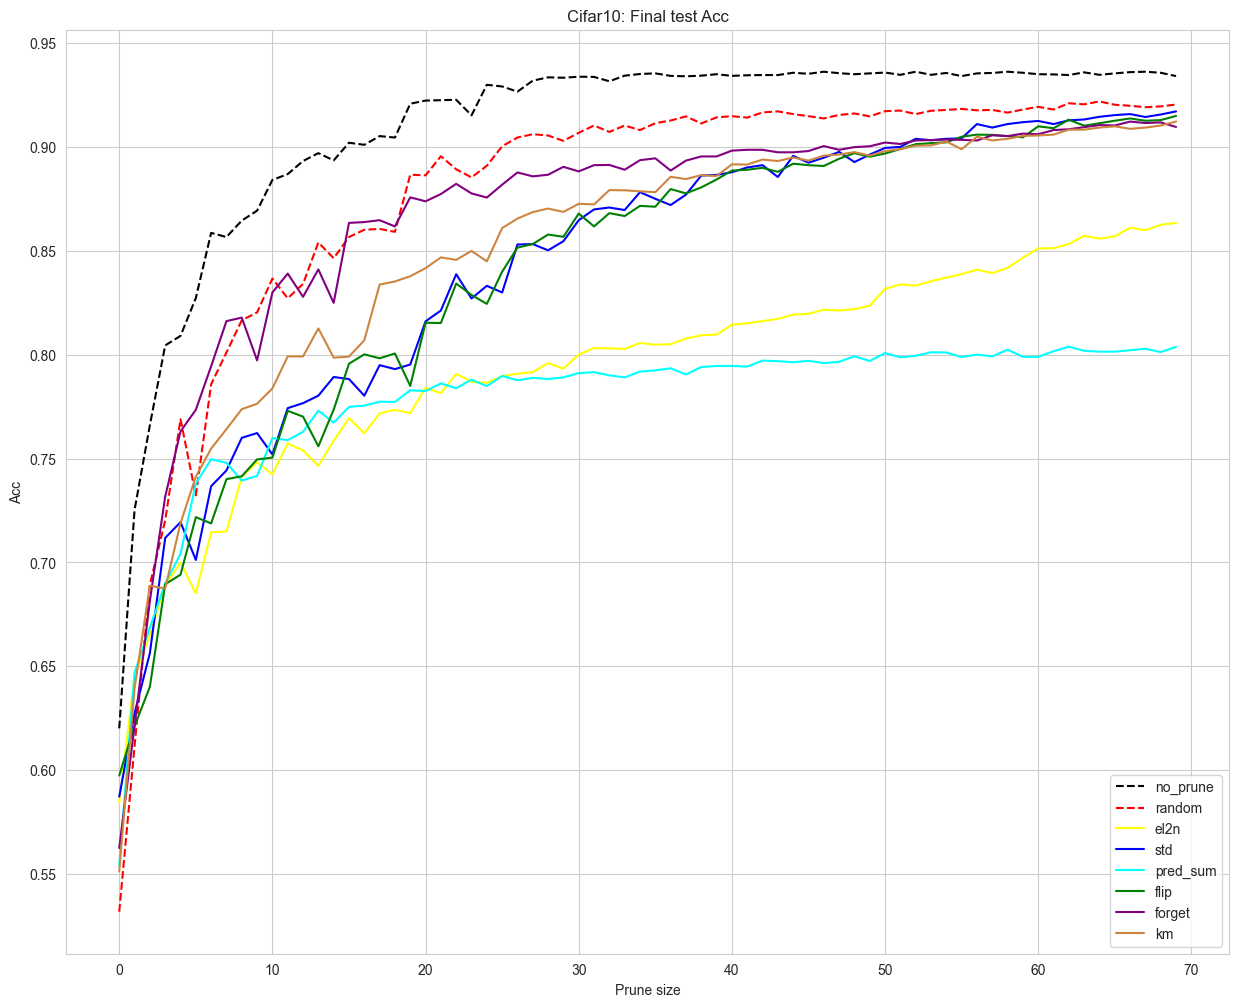

In [14]:
plt.figure(figsize=(15, 12))
#
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru','indianred',   'hotpink','darkorange','deepskyblue')
#          no       rand    el2n     std     sum     flip      forget   km      km5            km10             km100        km200
markers = ('dashed', 'solid')

for i, (prune_method,valid_acc) in enumerate(acc.items()):
        plt.plot(range(70), valid_acc[:70], label=prune_method,
                 c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()

In [15]:
exp_num = 2
already_trained_2 = True
print()
for name, idx in idx_sorted.items():
    model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_exp{exp_num}', dir_=NOTEBOOK_NAME,
                                 load=already_trained_2)
    model_manager.scheduler = torch.optim.lr_scheduler.MultiStepLR(model_manager.optimizer,
                                                                   milestones=[10, 15, 20, 25, 30], gamma=0.5,
                                                                   verbose=True)

    for epochs, presents in [(10, .5), (5, .6), (5, .7), (5, .8), (5, .9), (40, 1.)]:
        print(f'====     train model with {presents}% according to {name} method    ======')
        if not already_trained_2:
            loader_train = get_loader(dataset_train, idx[:round(presents * NUM_TRAIN)], batch_size=BATCH_SIZE,
                                      shuffle=True)
            model_manager.train(loader_train, loader_test, loader_test, epochs)
        acc[name]=model_manager.data['valid']['acc']
        print()


Adjusting learning rate of group 0 to 3.1250e-05.
====     train model with 0.5% according to random method    ======

====     train model with 0.6% according to random method    ======

====     train model with 0.7% according to random method    ======

====     train model with 0.8% according to random method    ======

====     train model with 0.9% according to random method    ======

====     train model with 1.0% according to random method    ======

Adjusting learning rate of group 0 to 3.1250e-05.
====     train model with 0.5% according to el2n method    ======

====     train model with 0.6% according to el2n method    ======

====     train model with 0.7% according to el2n method    ======

====     train model with 0.8% according to el2n method    ======

====     train model with 0.9% according to el2n method    ======

====     train model with 1.0% according to el2n method    ======

Adjusting learning rate of group 0 to 3.1250e-05.
====     train model with 0.5% ac

In [16]:
exp_num = 3
already_trained_3 = True
print()
for name, idx in idx_sorted.items():
    model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_exp{exp_num}', dir_=NOTEBOOK_NAME,
                                 load=already_trained_3)
    for epochs, presents in [(10, .5), (10, .6), (10, .7), (10, .8), (10, .9), (20, 1.)]:
        print(f'====     train model with {presents}% according to {name} method    ======')
        if not already_trained_3:
            loader_train = get_loader(dataset_train, idx[:round(presents * NUM_TRAIN)], batch_size=BATCH_SIZE,
                                      shuffle=True)
            model_manager.train(loader_train, loader_test, loader_test, epochs)

        acc[name]=model_manager.data['valid']['acc']
        print()


====     train model with 0.5% according to random method    ======

====     train model with 0.6% according to random method    ======

====     train model with 0.7% according to random method    ======

====     train model with 0.8% according to random method    ======

====     train model with 0.9% according to random method    ======

====     train model with 1.0% according to random method    ======

====     train model with 0.5% according to el2n method    ======

====     train model with 0.6% according to el2n method    ======

====     train model with 0.7% according to el2n method    ======

====     train model with 0.8% according to el2n method    ======

====     train model with 0.9% according to el2n method    ======

====     train model with 1.0% according to el2n method    ======

====     train model with 0.5% according to std method    ======

====     train model with 0.6% according to std method    ======

====     train model with 0.7% according to std met

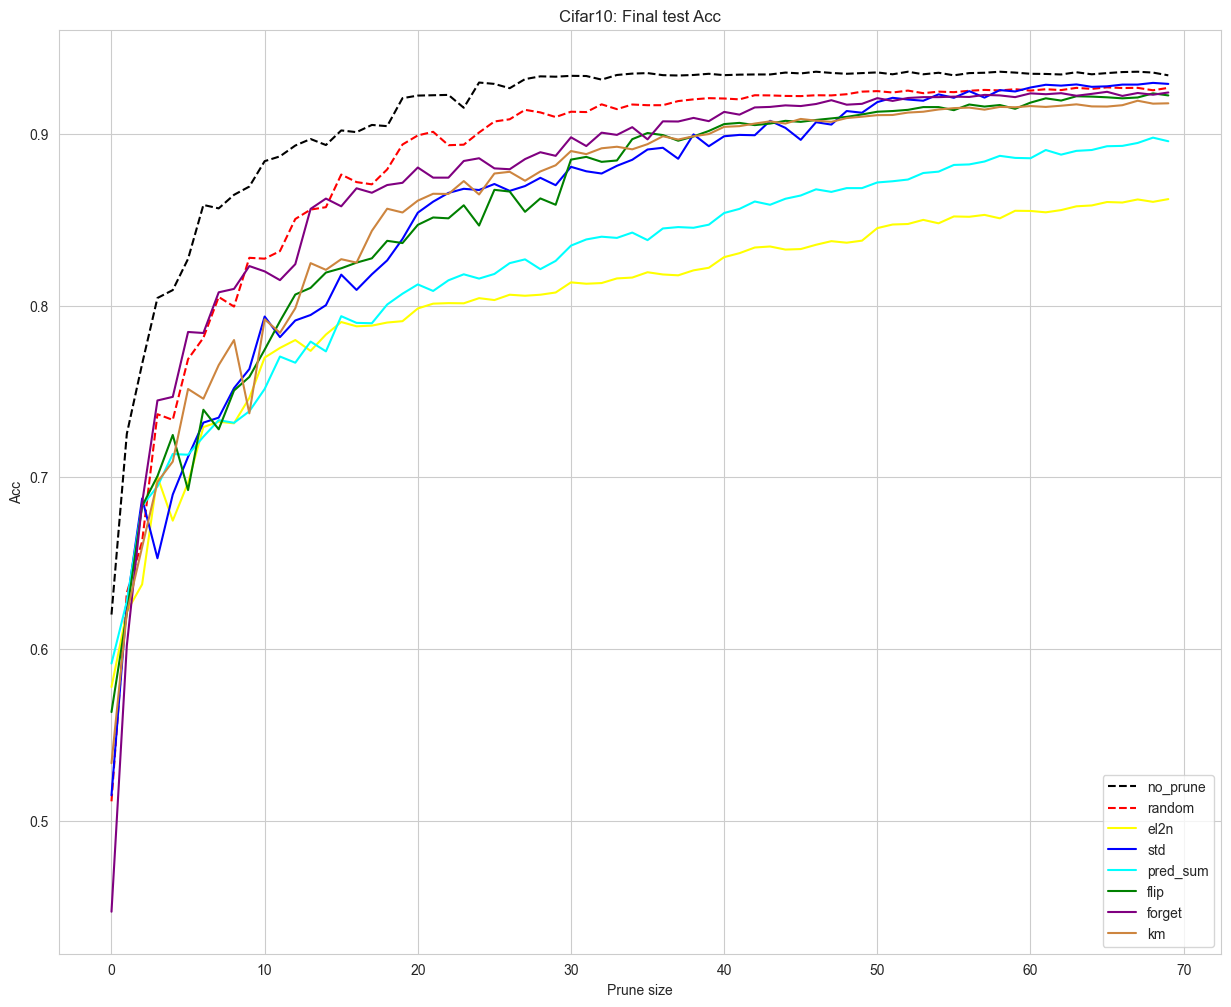

In [17]:
print()
plt.figure(figsize=(15, 12))
#
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'indianred', 'hotpink', 'darkorange',
          'deepskyblue')
#          no       rand    el2n     std     sum     flip      forget   km      km5            km10             km100        km200
markers = ('dashed', 'solid')

for i, (prune_method, valid_acc) in enumerate(acc.items()):
    plt.plot(range(70), valid_acc[:70], label=prune_method,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()

In [18]:
exp_num = 4
already_trained_4 = True
print()
for name, idx in idx_sorted.items():
    model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_exp{exp_num}', dir_=NOTEBOOK_NAME,
                                 load=already_trained_4)
    model_manager.scheduler = torch.optim.lr_scheduler.MultiStepLR(model_manager.optimizer,
                                                                   milestones=[10, 20, 30, 40, 50, 60, 70], gamma=0.5,
                                                                   verbose=True)

    for epochs, presents in [(10, .5), (10, .6), (10, .7), (10, .8), (10, .9), (20, 1.)]:
        print(f'====     train model with {presents}% according to {name} method    ======')
        if not already_trained_4:
            loader_train = get_loader(dataset_train, idx[:round(presents * NUM_TRAIN)], batch_size=BATCH_SIZE,
                                      shuffle=True)
            model_manager.train(loader_train, loader_test, loader_test, epochs)
        acc[name]=model_manager.data['valid']['acc']
        print()


Adjusting learning rate of group 0 to 3.1250e-05.
====     train model with 0.5% according to random method    ======

====     train model with 0.6% according to random method    ======

====     train model with 0.7% according to random method    ======

====     train model with 0.8% according to random method    ======

====     train model with 0.9% according to random method    ======

====     train model with 1.0% according to random method    ======

Adjusting learning rate of group 0 to 7.8125e-06.
====     train model with 0.5% according to el2n method    ======

====     train model with 0.6% according to el2n method    ======

====     train model with 0.7% according to el2n method    ======

====     train model with 0.8% according to el2n method    ======

====     train model with 0.9% according to el2n method    ======

====     train model with 1.0% according to el2n method    ======

Adjusting learning rate of group 0 to 1.5625e-05.
====     train model with 0.5% ac

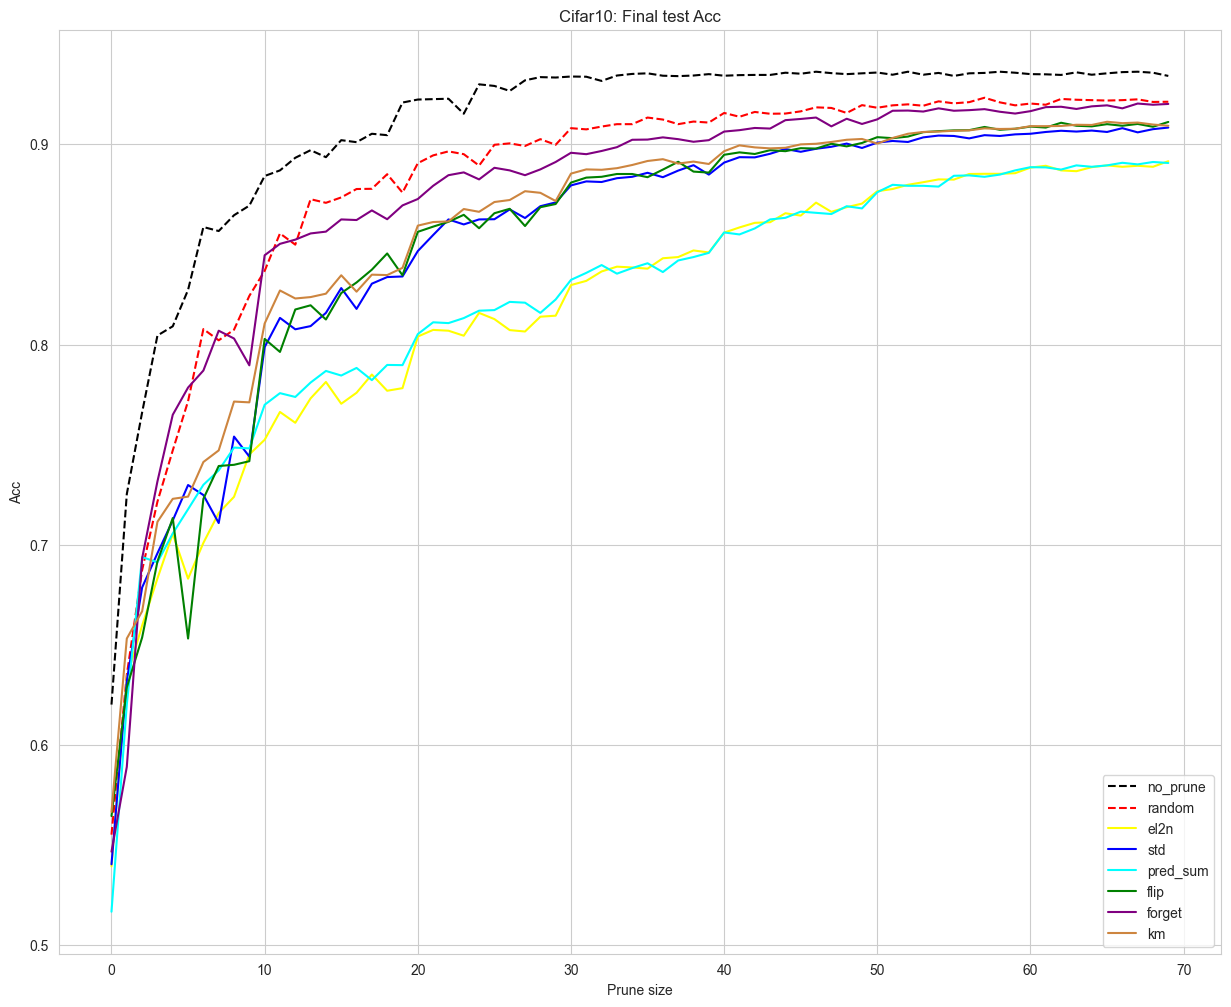

In [19]:
print()
plt.figure(figsize=(15, 12))
#
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'indianred', 'hotpink', 'darkorange',
          'deepskyblue')
#          no       rand    el2n     std     sum     flip      forget   km      km5            km10             km100        km200
markers = ('dashed', 'solid')

for i, (prune_method, valid_acc) in enumerate(acc.items()):
    plt.plot(range(70), valid_acc[:70], label=prune_method,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()